<a href="https://colab.research.google.com/github/GeorgeKonstantinosDimou/Skroutz/blob/main/Thesis_simpleClf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from IPython.display import Markdown
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
import time

In [ ]:
ds = pd.read_csv("/content/drive/MyDrive/Πτυχιακή/original.csv")
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [ ]:
ds.drop(columns="isFlaggedFraud", inplace = True)
ds = ds[~(ds['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT']))]

encoder = {}
for i in ds.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    ds[i] = encoder[i].fit_transform(ds[i])

X = ds.drop('isFraud', axis=1)
y = ds['isFraud']

In [ ]:
time_needed = time.time()

knn_pipeline = Pipeline(
    [('feature_selection', SelectKBest(f_classif, k=5)),
    ('scaler', StandardScaler()),
    ('resampler1', SMOTE(sampling_strategy='minority', random_state=42)),
    ('resampler2', RandomUnderSampler(sampling_strategy='all', random_state=42)),
    ('clf', KNeighborsClassifier())])

params_grid_knn = { 
          'clf__n_neighbors':   [4],
          'clf__weights':   ['uniform']
  }

skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = sklearn.model_selection.GridSearchCV(knn_pipeline, params_grid_knn, scoring=['precision', 'recall'], refit='precision', cv=skf)

grid_search.fit(X, y)

display(Markdown(
    "### Καλύτερα αποτελέσματα μέσω cross validation για k-Nearest neighbors:\n" +
    "**Best number of neighbors**: {}".format(grid_search.best_params_['clf__n_neighbors']) + "<br>" +
    "**Best weight**: {}".format(grid_search.best_params_['clf__weights']) + "<br>" +
    "**Best score:** {:.3f}".format(grid_search.best_score_)
))
#print("Best parameters: ", grid_search.best_params_)
#print("Best score: ", grid_search.best_score_)

### Καλύτερα αποτελέσματα μέσω cross validation για k-Nearest neighbors:
**Best number of neighbors**: 4<br>**Best number of neighbors**: uniform<br>**Best score:** 0.228

In [ ]:
best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

best_clf = KNeighborsClassifier(**best_params)

display(Markdown("### Αποτελέσματα k-Nearest neighbors:\n"))
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    display(Markdown("####Fold {}####".format(i+1)))

    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    #X_temp_resampled, y_temp_resampled = knn_pipeline['resampler1'].fit_resample(X_train, y_train) #use resampler1
    #X_resampled, y_resampled = knn_pipeline['resampler2'].fit_resample(X_temp_resampled, y_temp_resampled) #use resampler2
    #best_clf.fit(X_resampled, y_resampled) #fit the classifier using the resampled data
    #y_pred = best_clf.predict(X_resampled)

    #non-resampled fit/predict
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)

    conf_matr = confusion_matrix(y_test, y_pred)

    display(Markdown(
    "**Precision**: {:.2f}".format(precision_score(y_test, y_pred)) + "<br>" +
    "**Recall**: {:.2f}".format(recall_score(y_test, y_pred)) + "<br>" +
    "**F1**: {:.2f}".format(f1_score(y_test, y_pred)) + "<br>" +
    "**Confusion matrix**:"
    ))

    print("\n".join([' '.join(['{:5}'.format(item) for item in row])
          for row in conf_matr]))
    #print(f"Confusion Matrix:\n {conf_matr}")
    #print(f"Elapsed time: {(time.time()-time_needed)/60} in seconds")

### Αποτελέσματα k-Nearest neighbors:


####Fold 1####

**Precision**: 0.77<br>**Recall**: 0.44<br>**F1**: 0.56<br>**Confusion matrix**:

91820    30
  128   101


####Fold 2####

**Precision**: 0.88<br>**Recall**: 0.43<br>**F1**: 0.58<br>**Confusion matrix**:

91837    13
  131    98


####Fold 3####

**Precision**: 0.77<br>**Recall**: 0.39<br>**F1**: 0.52<br>**Confusion matrix**:

91824    27
  138    90


####Fold 4####

**Precision**: 0.88<br>**Recall**: 0.48<br>**F1**: 0.62<br>**Confusion matrix**:

91836    15
  118   110


####Fold 5####

**Precision**: 0.85<br>**Recall**: 0.44<br>**F1**: 0.58<br>**Confusion matrix**:

91832    18
  128   100


In [ ]:
selected_mask = grid_search.best_estimator_.named_steps['feature_selection'].get_support()
#feature_names = list(range(X.shape[1])) # Replace this with the actual feature names
#selected_features = [feature_names[i] for i in range(len(selected_mask)) if selected_mask[i]]
selected_features = X.columns[selected_mask]

#X.columns.to_numpy().tolist()
print("Selected features: ", selected_features)
#selected_features = knn_pipeline.named_steps['feature_selection'].get_feature_names_out()
#print(selected_features)

Selected features:  Index(['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest'], dtype='object')


<AxesSubplot:>

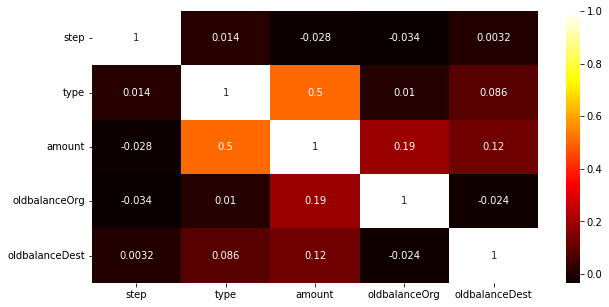

In [ ]:
plt.figure(figsize=(10, 5))
sns.heatmap(ds.loc[:, selected_features].corr(), annot=True, cmap='hot')

In [ ]:
def train_test(clf_dictionary: dict, clfier: str):

  time_needed = time.time()

  clf_pipeline = Pipeline(
      [('feature_selection', SelectKBest(f_classif, k=5)),
      ('scaler', StandardScaler()),
      ('resampler1', SMOTE(sampling_strategy='minority', random_state=42)),
      ('resampler2', RandomUnderSampler(sampling_strategy='all', random_state=42)),
      ('clf', clf_dictionary[clfier]['method'])])

  params_grid = clf_dictionary[clfier]['params_grid']

  skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  grid_search = sklearn.model_selection.GridSearchCV(clf_pipeline, params_grid, scoring=['precision', 'recall'], refit='precision', cv=skf)

  grid_search.fit(X, y)

  display(Markdown(
      "### Καλύτερα αποτελέσματα μέσω cross validation για {}:\n".format(clf_dictionary[clfier]['name']) +
      "{}".format(grid_search.best_params_) + "<br>" +
      #"**Best number of neighbors**: {}".format(grid_search.best_params_['clf__n_neighbors']) + "<br>" +
      #"**Best weight**: {}".format(grid_search.best_params_['clf__weights']) + "<br>" +
      "**Best score:** {:.3f}".format(grid_search.best_score_)
  ))

  #test
  best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

  best_clf = clf_dictionary[clfier]['method'](**best_params)

  display(Markdown("### Αποτελέσματα {}:\n".format(clf_dictionary[clfier]['name'])))
  for i, (train_index, test_index) in enumerate(skf.split(X, y)):
      display(Markdown("####Fold {}####".format(i+1)))

      X_train, y_train = X.iloc[train_index], y.iloc[train_index]
      X_test, y_test = X.iloc[test_index], y.iloc[test_index]

      #X_temp_resampled, y_temp_resampled = knn_pipeline['resampler1'].fit_resample(X_train, y_train) #use resampler1
      #X_resampled, y_resampled = knn_pipeline['resampler2'].fit_resample(X_temp_resampled, y_temp_resampled) #use resampler2
      #best_clf.fit(X_resampled, y_resampled) #fit the classifier using the resampled data
      #y_pred = best_clf.predict(X_resampled)

      #non-resampled fit/predict
      best_clf.fit(X_train, y_train)
      y_pred = best_clf.predict(X_test)

      conf_matr = confusion_matrix(y_test, y_pred)

      display(Markdown(
      "**Precision**: {:.2f}".format(precision_score(y_test, y_pred)) + "<br>" +
      "**Recall**: {:.2f}".format(recall_score(y_test, y_pred)) + "<br>" +
      "**F1**: {:.2f}".format(f1_score(y_test, y_pred)) + "<br>" +
      "**Confusion matrix**:"
      ))

      print("\n".join([' '.join(['{:5}'.format(item) for item in row])
            for row in conf_matr]))
      #print(f"Confusion Matrix:\n {conf_matr}")
      #print(f"Elapsed time: {(time.time()-time_needed)/60} in seconds")

In [ ]:
def main():

  classifiers_dict = {
    'clf1': {
        'name': 'K-Nearest Neighbor',
        'method': KNeighborsClassifier(),
        'params_grid': { 'clf__n_neighbors': [4],
                         'clf__weights':   ['uniform']
        }
    },
    'clf2': {
        'name': 'Logistic Regression',
        'method': LogisticRegression(),
        'params_grid': { 'clf__C': np.logspace(-6, -5, 10)
        }
    },
    'clf3': {
        'name': 'SVM',
        'method' : SVC(),
        'params_grid': { 'clf__C': [1, 10, 20]
                            #'clf__kernel': ['linear', 'poly'],
                            #'clf__degree': [2],
                            #'clf__gamma': ['scale']
        }
    },
    'clf4': {
        'name': 'Naive_Bayes',
        'method': GaussianNB(),
        'params_grid': { 'clf__criterion': ["gini", 'entropy', 'log_loss'],
                         'clf__max_leaf_nodes': [4, 5, 6]
        }
    },
    'clf5': {
        'name': 'Decision_Tree',
        'method': DecisionTreeClassifier(),
        'params_grid': { 'clf__criterion': ["gini", 'entropy', 'log_loss'],
                         'clf__max_leaf_nodes': [4, 5, 6]
        }
    },
    'clf6': {
        'name': 'Random_forest',
        'method': RandomForestClassifier(),
        'params_grid': { 'clf__n_estimators': [50, 100, 150],
                         'clf__criterion': ['gini', "entropy"]
        }
    },
    'clf7': {
        'name': 'XGBoost',
        'method': XGBClassifier(),
        'params_grid': { 'clf__n_estimators': range(50, 150, 50)
          }
      }
  }

  train_test(classifiers_dict, 'clf2')

if __name__ == '__main__':
  main()

### Καλύτερα αποτελέσματα μέσω cross validation για Logistic Regression:
{'clf__C': 1e-06}<br>**Best score:** 0.043

TypeError: ignored

In [ ]:
from sklearn.linear_model import LogisticRegression

time_needed = time.time()

logisticReg_pipeline = Pipeline(
    [('feature_selection', SelectKBest(f_classif, k=5)),
     ('scaler', StandardScaler()),
     ('resampler1', SMOTE(random_state=42)),
     ('resampler2', RandomUnderSampler(random_state=42)),
     ('clf', LogisticRegression())])

params_grid_logReg = {
    'clf__C': np.logspace(-6, -5, 10)
}

skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = sklearn.model_selection.GridSearchCV(logisticReg_pipeline, params_grid_logReg, scoring='accuracy', cv=skf)

grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'clf__C': 1e-06}
Best score:  0.9636072583662842


In [ ]:
best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

best_clf = LogisticRegression(**best_params)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}")
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")
    print(f"Elapsed time: {(time.time()-time_needed)/60} in seconds")

Fold 1
Accuracy: 0.9981754797510833
Elapsed time: 1.4453669309616088 in seconds
Fold 2
Accuracy: 0.9983166628655828
Elapsed time: 1.5484772721926372 in seconds
Fold 3
Accuracy: 0.9980777375948914
Elapsed time: 1.6008061607678732 in seconds
Fold 4
Accuracy: 0.9983601038238904
Elapsed time: 1.6457454085350036 in seconds
Fold 5
Accuracy: 0.998197180651187
Elapsed time: 1.6920347094535828 in seconds


In [ ]:
from sklearn.naive_bayes import GaussianNB

time_needed = time.time()

naive_pipeline = Pipeline(
    [('feature_selection', SelectKBest(f_classif, k=5)),
     ('scaler', StandardScaler()),
     ('resampler1', SMOTE(random_state=42)),
     ('resampler2', RandomUnderSampler(random_state=42)),
     ('clf', GaussianNB())])

param_grid_naive = {'clf__var_smoothing': [1e-9, 1e-8, 1e-7],
              'clf__priors': [None, [0.4, 0.6], [0.3, 0.7]]}

skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = sklearn.model_selection.GridSearchCV(naive_pipeline, param_grid_naive, scoring='accuracy', cv=skf)

grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'clf__priors': None, 'clf__var_smoothing': 1e-09}
Best score:  0.9481031442076429


In [ ]:
best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

best_clf = GaussianNB(**best_params)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}")
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")
    print(f"Elapsed time: {(time.time()-time_needed)/60} in seconds")

Fold 1
Accuracy: 0.9807882361884903
Elapsed time: 0.5401689370473226 in seconds
Fold 2
Accuracy: 0.9802235037304923
Elapsed time: 0.542344347635905 in seconds
Fold 3
Accuracy: 0.9811357638549506
Elapsed time: 0.5445805152257284 in seconds
Fold 4
Accuracy: 0.9802995254075305
Elapsed time: 0.5469307025273641 in seconds
Fold 5
Accuracy: 0.9795173657116792
Elapsed time: 0.549260417620341 in seconds


In [ ]:
from sklearn.tree import DecisionTreeClassifier

time_needed = time.time()

tree_pipeline = Pipeline(
    [('feature_selection', SelectKBest(f_classif, k=5)),
     ('scaler', StandardScaler()),
     ('resampler1', SMOTE(random_state=42)),
     ('resampler2', RandomUnderSampler(random_state=42)),
     ('clf', DecisionTreeClassifier())])

param_grid_tre = {'clf__criterion': ["gini", 'entropy', 'log_loss'],
              'clf__max_leaf_nodes': [4, 5, 6]}

skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = sklearn.model_selection.GridSearchCV(tree_pipeline, param_grid_tre, scoring='accuracy', cv=skf)

grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'clf__criterion': 'entropy', 'clf__max_leaf_nodes': 5}
Best score:  0.948313781690423


In [ ]:
best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

best_clf = DecisionTreeClassifier(**best_params)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}")
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")
    print(f"Elapsed time: {(time.time()-time_needed)/60} in seconds")

Fold 1
Accuracy: 0.9983492435843134
Elapsed time: 2.7333113153775535 in seconds
Fold 2
Accuracy: 0.9984578459800824
Elapsed time: 2.7608473539352416 in seconds
Fold 3
Accuracy: 0.9983709640634673
Elapsed time: 2.797973342736562 in seconds
Fold 4
Accuracy: 0.9983275231051597
Elapsed time: 2.825815534591675 in seconds
Fold 5
Accuracy: 0.9987510588848585
Elapsed time: 2.8617082754770915 in seconds


In [ ]:
from sklearn.ensemble import RandomForestClassifier

time_needed = time.time()

forest_pipeline = Pipeline(
    [('feature_selection', SelectKBest(f_classif, k=5)),
     ('scaler', StandardScaler()),
     ('resampler1', SMOTE(random_state=42)),
     ('resampler2', RandomUnderSampler(random_state=42)),
     ('clf', RandomForestClassifier())])

param_grid_fores = {'clf__n_estimators': [50, 100, 150],
              'clf__criterion': ['gini', "entropy"]}

skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = sklearn.model_selection.GridSearchCV(forest_pipeline, param_grid_fores, scoring='accuracy', cv=skf)

grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'clf__criterion': 'gini', 'clf__n_estimators': 50}
Best score:  0.9981385509971226


In [ ]:
best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

best_clf = RandomForestClassifier(**best_params)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}")
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")
    print(f"Elapsed time: {(time.time()-time_needed)/60} in seconds")

Fold 1
Accuracy: 0.9994026868232713
Elapsed time: 113.54401630560557 in seconds
Fold 2
Accuracy: 0.9994461277815788
Elapsed time: 115.06471886634827 in seconds
Fold 3
Accuracy: 0.999435267542002
Elapsed time: 116.67034480571746 in seconds
Fold 4
Accuracy: 0.9993809663441175
Elapsed time: 118.23058296442032 in seconds
Fold 5
Accuracy: 0.9994461217663285
Elapsed time: 119.86167944669724 in seconds


In [ ]:
from xgboost import XGBClassifier

time_needed = time.time()

xgb_pipeline = Pipeline(
    [('feature_selection', SelectKBest(f_classif, k=5)),
     ('scaler', StandardScaler()),
     ('resampler1', SMOTE(random_state=42)),
     ('resampler2', RandomUnderSampler(random_state=42)),
     ('clf', XGBClassifier())],
     verbose=True)

param_grid_xgb = {'clf__n_estimators': range(50, 150, 50)}

skf = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = sklearn.model_selection.GridSearchCV(xgb_pipeline, param_grid_xgb, scoring='accuracy', cv=skf)

grid_search.fit(X, y)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

[Pipeline] . (step 1 of 5) Processing feature_selection, total=   0.1s
[Pipeline] ............ (step 2 of 5) Processing scaler, total=   0.0s
[Pipeline] ........ (step 3 of 5) Processing resampler1, total=   0.2s
[Pipeline] ........ (step 4 of 5) Processing resampler2, total=   0.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  55.0s
[Pipeline] . (step 1 of 5) Processing feature_selection, total=   0.1s
[Pipeline] ............ (step 2 of 5) Processing scaler, total=   0.0s
[Pipeline] ........ (step 3 of 5) Processing resampler1, total=   0.2s
[Pipeline] ........ (step 4 of 5) Processing resampler2, total=   0.3s
[Pipeline] ............... (step 5 of 5) Processing clf, total=  50.6s
[Pipeline] . (step 1 of 5) Processing feature_selection, total=   0.1s
[Pipeline] ............ (step 2 of 5) Processing scaler, total=   0.0s
[Pipeline] ........ (step 3 of 5) Processing resampler1, total=   0.1s
[Pipeline] ........ (step 4 of 5) Processing resampler2, total=   0.2s
[Pipel

In [ ]:
best_params = {k.split('__')[1]: v for k, v in grid_search.best_params_.items()}

best_clf = XGBClassifier(**best_params)

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print(f"Fold {i+1}")
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    best_clf.fit(X_train, y_train)
    y_pred = best_clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc}")
    print(f"Elapsed time: {(time.time()-time_needed)/60} in seconds")

Fold 1
Accuracy: 0.9994787085003095
Elapsed time: 16.852334209283192 in seconds
Fold 2
Accuracy: 0.9995873108960783
Elapsed time: 18.052921636899313 in seconds
Fold 3
Accuracy: 0.9995655904169246
Elapsed time: 19.228132383028665 in seconds
Fold 4
Accuracy: 0.9994895687398864
Elapsed time: 20.3882496992747 in seconds
Fold 5
Accuracy: 0.9995655856990812
Elapsed time: 21.499321846167245 in seconds
